# Covariance/correlation between features

## Aim

Measure the correlation between features. Uses full dataset (i.e. just restricted by number of admissions - and not by whether arrived within 4 hours of known stroke onset).

Replicates SAMueL-1 analyses [available here](https://samuel-book.github.io/samuel-1/descriptive_stats/07_covariance.html)


## Set up

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dataclasses import dataclass
from matplotlib import cm
from sklearn.preprocessing import StandardScaler

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Restrict data

Note: In SAMueL-1, they used '../data/10k_training_test/cohort_10000_train.csv'. This appears to have some differences to what I have done below including:
* One hot encoding for variables with missing values (e.g. AFAnticoagulentHeparin_No, AFAnticoagulentHeparin_missing)
* One hot encoding variables that we have as numerical (e.g. admission year is S1AdmissionYear_2018, S1AdmissionYear_2017, S1AdmissionYear_2016)

In [4]:
# Drop ID and categorical variables
df = data_full.drop(['id', 'stroke_team',
                     'weekday', 'discharge_destination'], axis=1)

# Find columns with NaN and drop them
df.columns[df.isna().any()]
df = df.dropna(axis=1)

# Show remaining data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358884 entries, 0 to 358883
Data columns (total 35 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   age                                       358884 non-null  float64
 1   male                                      358884 non-null  int64  
 2   infarction                                358884 non-null  float64
 3   onset_known                               358884 non-null  int64  
 4   precise_onset_known                       358884 non-null  int64  
 5   onset_during_sleep                        358884 non-null  int64  
 6   month                                     358884 non-null  int64  
 7   year                                      358884 non-null  int64  
 8   arrival_time_3_hour_period                358884 non-null  int64  
 9   arrival_to_scan_time                      358884 non-null  float64
 10  thrombolysis        

## Scale data

Covariance is not standardised, so cannot be used to compare strength of relationship, and only indicates direction. Correlation is standardised, meaning it can be used to make comparisons.

After scaling the data, the reported covariance will be the correlation between data features.

In [5]:
sc = StandardScaler()
sc.fit(df)
df_std = sc.transform(df)
df_std = pd.DataFrame(df_std, columns=list(df))

## Get covariance of scaled data (correlation)

Also calculated R-squared, which is the square of the correlation.  Whilst correlation measures the strength of the relationship, R-squared indicates the percentage of variance in one variable explained by the other variable.

In [6]:
# Get covariance
cov = df_std.cov()

# Convert from wide to tall
cov = cov.melt(ignore_index=False)

# Remove correlation with self
cov = cov[cov.index != cov['variable']]

# Add absolute correlation (ie. +/- becomes +)
cov['abs_value'] = np.abs(cov['value'])

# Add R-squared
cov['r-squared'] = cov['value'] ** 2

# Sort by absolute covariance
cov.sort_values('abs_value', inplace=True, ascending=False)

# Round to four decimal places
cov = cov.round(4)

# Remove duplicate pairs of features
result = []
for index, values in cov.iterrows():
    combination = [index, values['variable']]
    combination.sort()
    string = combination[0] + "-" + combination[1]
    result.append(string)
cov['pair'] = result
cov.sort_values('pair', inplace=True)
cov.drop_duplicates(subset=['pair'], inplace=True)

# Sort by r-squared
cov.sort_values('r-squared', ascending=False, inplace=True)

In [7]:
cov

,variable,value,abs_value,r-squared,pair
infarction,thrombolysis_no_but_haemorrhagic,-0.9857,0.9857,0.9716,infarction-thrombolysis_no_but_haemorrhagic
nihss_arrival_loc,stroke_severity,0.6086,0.6086,0.3704,nihss_arrival_loc-stroke_severity
precise_onset_known,onset_known,0.4992,0.4992,0.2492,onset_known-precise_onset_known
precise_onset_known,thrombolysis_no_but_time_unknown_wake_up,-0.4518,0.4518,0.2041,precise_onset_known-thrombolysis_no_but_time_u...
thrombolysis_no_but_time_unknown_wake_up,onset_known,-0.4383,0.4383,0.1921,onset_known-thrombolysis_no_but_time_unknown_w...
...,...,...,...,...,...
hypertension,thrombolysis_no_no_reason,-0.0050,0.0050,0.0000,hypertension-thrombolysis_no_no_reason
hypertension,thrombolysis_no_but_refusal,-0.0022,0.0022,0.0000,hypertension-thrombolysis_no_but_refusal
hypertension,thrombolysis_no_but_other_medical,-0.0039,0.0039,0.0000,hypertension-thrombolysis_no_but_other_medical
hypertension,thrombolysis_no_but_improving,-0.0071,0.0071,0.0000,hypertension-thrombolysis_no_but_improving


## Investigate distribution of R-squared values

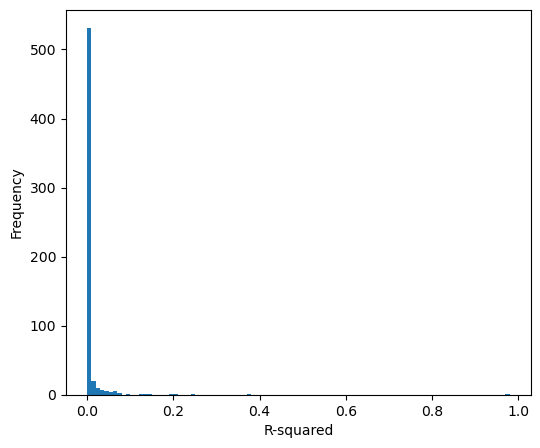

In [8]:
# Plot frequency of the different R-squared values
fig, ax = plt.subplots(figsize=(6, 5))
bins = np.arange(min(cov['r-squared']), max(cov['r-squared'])+0.01, 0.01)
ax.hist(cov['r-squared'], bins=bins)
ax.set_xlabel('R-squared')
ax.set_ylabel('Frequency')
plt.show()

In [9]:
# Count proportion of results in the following bins
bins = [0, 0.10, 0.25, 0.5, 0.75, 0.99, 1.1]
counts = np.histogram(cov['r-squared'], bins=bins)[0]
counts = counts / counts.sum()

labels = ['<0.10', '0.1 to 0.25', '0.25 to 0.50', '0.50 to 0.75',
          '0.75 to 0.999', '1']
counts_df = pd.DataFrame(index=labels)
counts_df['Proportion'] = counts
counts_df['Cumulative Proportion'] = counts.cumsum()
counts_df.index.name = 'R-squared'
counts_df

,Proportion,Cumulative Proportion
R-squared,,
<0.10,0.986555,0.986555
0.1 to 0.25,0.010084,0.996639
0.25 to 0.50,0.001681,0.998319
0.50 to 0.75,0.000000,0.998319
0.75 to 0.999,0.001681,1.000000
1,0.000000,1.000000


## Show highly correlated features

In [10]:
cov[cov['r-squared'] > 0.999]

,variable,value,abs_value,r-squared,pair


In [11]:
cov[cov['r-squared'] > 0.5]

,variable,value,abs_value,r-squared,pair
infarction,thrombolysis_no_but_haemorrhagic,-0.9857,0.9857,0.9716,infarction-thrombolysis_no_but_haemorrhagic
